In [1]:
!pip install prophet dagshub scikit-learn pandas numpy mlflow==2.2.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mlflow
import mlflow.pytorch
import dagshub
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'nipkha21'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '202fb8a4c58a90b0eb3598b1037498eb6fe9f593'

dagshub.init(repo_owner='TomC333', repo_name='ml-walmart-recruiting', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/TomC333/ml-walmart-recruiting.mlflow')

print("MLflow setup completed")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=68623473-051e-43a1-8f59-96acba035def&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=4b3784f7df410b5253fe27cdd0b3bc975e4e6ba3b7a50cd4c170c045ae9362b8




Accessing as nipkha21

Initialized MLflow to track repo "TomC333/ml-walmart-recruiting"

Repository TomC333/ml-walmart-recruiting initialized!

MLflow setup completed


In [5]:
print("Loading data...")
features_data = pd.read_csv('features.csv')
train_data = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')

print(f"Features data shape: {features_data.shape}")
print(f"Train data shape: {train_data.shape}")
print(f"Stores data shape: {stores.shape}")

Loading data...
Features data shape: (8190, 12)
Train data shape: (421570, 5)
Stores data shape: (45, 3)


In [6]:
df = train_data.merge(features_data, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

if 'IsHoliday_y' in df.columns:
    df.drop(['IsHoliday_y'], axis=1, inplace=True)
    df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

print(f"Merged dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Merged dataset shape: (421570, 16)
Date range: 2010-02-05 to 2012-10-26


In [7]:
print("Applying comprehensive feature engineering pipeline...")

# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Store', 'Dept', 'Date'])

# Remove negative sales (returns/adjustments)
print(f"Negative sales records: {len(df[df['Weekly_Sales'] < 0])}")
df = df[df['Weekly_Sales'] >= 0]

# Create lag features for Weekly_Sales
lags = [1, 2, 3, 4, 52]  # Common lags: 1–4 weeks and 1 year (52 weeks)

for lag in lags:
    df[f'Weekly_Sales_lag_{lag}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

# Create Sales_diff1 (but won't use it as noted)
df['Sales_diff1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].diff()

# Create time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Create change features for external variables
for col in ['Fuel_Price', 'CPI', 'Unemployment']:
    if col in df.columns:
        df[f'{col}_change'] = df.groupby(['Store', 'Dept'])[col].diff()
        df[f'{col}_pct_change'] = df.groupby(['Store', 'Dept'])[col].pct_change()

# Create lag features for external variables
for lag in [1, 2, 4, 8, 12]:
    for col in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
        if col in df.columns:
            df[f'{col}_lag_{lag}'] = df.groupby(['Store', 'Dept'])[col].shift(lag)

print("Lag features created")

Applying comprehensive feature engineering pipeline...
Negative sales records: 1285
Lag features created


In [8]:
df['is_outlier'] = ((df['Weekly_Sales'] < -25108.67) | (df['Weekly_Sales'] > 847494.61)).astype(int)
outlier_propensity_store = df.groupby('Store')['is_outlier'].mean()
outlier_propensity_dept = df.groupby('Dept')['is_outlier'].mean()
df['store_outlier_propensity'] = df['Store'].map(outlier_propensity_store)
df['dept_outlier_propensity'] = df['Dept'].map(outlier_propensity_dept)
df['is_outlier_lag1'] = df.groupby(['Store', 'Dept'])['is_outlier'].shift(1)
df['outlier_count_last_4weeks'] = df.groupby(['Store', 'Dept'])['is_outlier'].rolling(4).sum().shift(1).reset_index(level=[0,1], drop=True)
df.drop('is_outlier', axis=1, inplace=True)

# Create holiday flags
df['Is_SuperBowl'] = np.where(df['Date'].isin(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']), 1, 0)
df['Is_LaborDay'] = np.where(df['Date'].isin(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']), 1, 0)
df['Is_Thanksgiving'] = np.where(df['Date'].isin(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']), 1, 0)
df['Is_Christmas'] = np.where(df['Date'].isin(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']), 1, 0)

print("Outlier and holiday features created")
print(f"Final dataset shape: {df.shape}")

Outlier and holiday features created
Final dataset shape: (420285, 60)


In [9]:
print("Handling missing values...")

# 1. DROP MARKDOWN COLUMNS (they're mostly empty)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
print("Dropping markdown columns with >90% missing values:")
for col in markdown_cols:
    if col in df.columns:
        missing_pct = df[col].isnull().sum() / len(df) * 100
        print(f"{col}: {missing_pct:.1f}% missing")
        df = df.drop(columns=[col])

# 2. HANDLE EXTERNAL FACTOR DERIVED FEATURES
external_derived_cols = [col for col in df.columns if any(x in col for x in ['change', 'pct_change'])
                        and any(y in col for y in ['Fuel_Price', 'CPI', 'Unemployment', 'Temperature'])]

for col in external_derived_cols:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            if 'change' in col:
                df[col] = df.groupby(['Store', 'Dept'])[col].ffill()
                df[col] = df[col].fillna(0)

# 3. HANDLE OUTLIER FEATURES
outlier_cols = [col for col in df.columns if 'outlier' in col.lower()]
for col in outlier_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# 4. FINAL CLEANUP
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

for col in remaining_missing.index:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df.groupby(['Store', 'Dept'])[col].ffill().bfill()
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df.groupby(['Store', 'Dept'])[col].ffill()
        df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown')

print("✅ All missing values handled successfully!")
print(f"Final clean dataset shape: {df.shape}")

Handling missing values...
Dropping markdown columns with >90% missing values:
MarkDown1: 64.3% missing
MarkDown2: 73.6% missing
MarkDown3: 67.5% missing
MarkDown4: 68.0% missing
MarkDown5: 64.1% missing
✅ All missing values handled successfully!
Final clean dataset shape: (420285, 55)


In [11]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, layer_size)] +
                                   [nn.Linear(layer_size, layer_size) for _ in range(layers-1)] +
                                   [nn.Linear(layer_size, theta_size)])
        self.basis_function = basis_function

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        theta = self.layers[-1](x)
        backcast, forecast = self.basis_function(theta)
        return backcast, forecast

class GenericBasis(nn.Module):
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta):
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, -self.forecast_size:]
        return backcast, forecast

class TrendBasis(nn.Module):
    def __init__(self, degree_of_polynomial, backcast_size, forecast_size):
        super().__init__()
        self.polynomial_size = degree_of_polynomial + 1
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta):
        backcast = theta[:, :self.polynomial_size]
        forecast = theta[:, self.polynomial_size:2*self.polynomial_size]

        # Create polynomial basis - fix device and dimension issues
        device = theta.device
        batch_size = theta.size(0)

        backcast_time = torch.arange(self.backcast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1) / self.backcast_size
        forecast_time = torch.arange(self.forecast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1) / self.forecast_size

        # Create basis matrices
        backcast_basis = torch.stack([backcast_time.pow(i) for i in range(self.polynomial_size)], dim=-1)  # [batch, backcast_size, polynomial_size]
        forecast_basis = torch.stack([forecast_time.pow(i) for i in range(self.polynomial_size)], dim=-1)  # [batch, forecast_size, polynomial_size]

        # Apply basis functions
        backcast_output = torch.sum(backcast.unsqueeze(1) * backcast_basis, dim=-1)  # [batch, backcast_size]
        forecast_output = torch.sum(forecast.unsqueeze(1) * forecast_basis, dim=-1)  # [batch, forecast_size]

        return backcast_output, forecast_output

class SeasonalityBasis(nn.Module):
    def __init__(self, harmonics, backcast_size, forecast_size):
        super().__init__()
        self.harmonics = harmonics
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta):
        backcast = theta[:, :2*self.harmonics]
        forecast = theta[:, 2*self.harmonics:4*self.harmonics]

        # Create seasonal basis - fix device and dimension issues
        device = theta.device
        batch_size = theta.size(0)

        backcast_time = torch.arange(self.backcast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1)
        forecast_time = torch.arange(self.forecast_size, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1)

        backcast_basis_list = []
        forecast_basis_list = []

        for i in range(self.harmonics):
            backcast_basis_list.append(torch.cos(2 * np.pi * (i+1) * backcast_time / self.backcast_size))
            backcast_basis_list.append(torch.sin(2 * np.pi * (i+1) * backcast_time / self.backcast_size))
            forecast_basis_list.append(torch.cos(2 * np.pi * (i+1) * forecast_time / self.forecast_size))
            forecast_basis_list.append(torch.sin(2 * np.pi * (i+1) * forecast_time / self.forecast_size))

        backcast_basis = torch.stack(backcast_basis_list, dim=-1)  # [batch, backcast_size, 2*harmonics]
        forecast_basis = torch.stack(forecast_basis_list, dim=-1)  # [batch, forecast_size, 2*harmonics]

        # Apply basis functions
        backcast_output = torch.sum(backcast.unsqueeze(1) * backcast_basis, dim=-1)  # [batch, backcast_size]
        forecast_output = torch.sum(forecast.unsqueeze(1) * forecast_basis, dim=-1)  # [batch, forecast_size]

        return backcast_output, forecast_output

class NBeats(nn.Module):
    def __init__(self, backcast_size, forecast_size, stack_types=['trend', 'seasonality'],
                 nb_blocks_per_stack=3, thetas_dim=[4, 8], nb_harmonics=None, share_weights_in_stack=False):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size
        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack

        self.stacks = nn.ModuleList()

        for stack_id, stack_type in enumerate(stack_types):
            if stack_type == 'trend':
                basis_function = TrendBasis(degree_of_polynomial=thetas_dim[stack_id],
                                          backcast_size=backcast_size, forecast_size=forecast_size)
                theta_size = 2 * (thetas_dim[stack_id] + 1)
            elif stack_type == 'seasonality':
                harmonics = nb_harmonics or min(forecast_size//2, 10)  # Limit harmonics to prevent issues
                basis_function = SeasonalityBasis(harmonics=harmonics,
                                                backcast_size=backcast_size, forecast_size=forecast_size)
                theta_size = 4 * harmonics
            else:  # generic
                basis_function = GenericBasis(backcast_size=backcast_size, forecast_size=forecast_size)
                theta_size = backcast_size + forecast_size

            stack = nn.ModuleList()
            for _ in range(nb_blocks_per_stack):
                block = NBeatsBlock(input_size=backcast_size, theta_size=theta_size,
                                  basis_function=basis_function, layers=4, layer_size=512)
                stack.append(block)
            self.stacks.append(stack)

    def forward(self, x):
        residuals = x
        forecast = torch.zeros(x.size(0), self.forecast_size, device=x.device)  # Fix device issue

        for stack in self.stacks:
            for block in stack:
                backcast, block_forecast = block(residuals)
                residuals = residuals - backcast
                forecast = forecast + block_forecast

        return forecast

print("✅ N-BEATS architecture implemented")

✅ N-BEATS architecture implemented


In [12]:
class WalmartTimeSeriesDataset(Dataset):
    def __init__(self, data, store_dept_combinations, backcast_size, forecast_size,
                 feature_cols=None, target_col='Weekly_Sales'):
        self.data = data
        self.combinations = store_dept_combinations
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size
        self.feature_cols = feature_cols or []
        self.target_col = target_col
        self.samples = []

        # Create samples
        for _, row in store_dept_combinations.iterrows():
            store, dept = row['Store'], row['Dept']
            store_dept_data = data[(data['Store'] == store) & (data['Dept'] == dept)].sort_values('Date')

            if len(store_dept_data) >= backcast_size + forecast_size:
                for i in range(len(store_dept_data) - backcast_size - forecast_size + 1):
                    sample_data = store_dept_data.iloc[i:i + backcast_size + forecast_size]

                    # Extract target values
                    backcast_target = sample_data[target_col].iloc[:backcast_size].values
                    forecast_target = sample_data[target_col].iloc[backcast_size:].values

                    # Extract features if specified
                    if feature_cols:
                        backcast_features = sample_data[feature_cols].iloc[:backcast_size].values
                        forecast_features = sample_data[feature_cols].iloc[backcast_size:].values
                        sample = {
                            'backcast_target': backcast_target,
                            'forecast_target': forecast_target,
                            'backcast_features': backcast_features,
                            'forecast_features': forecast_features,
                            'store': store,
                            'dept': dept
                        }
                    else:
                        sample = {
                            'backcast_target': backcast_target,
                            'forecast_target': forecast_target,
                            'store': store,
                            'dept': dept
                        }

                    self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        backcast = torch.FloatTensor(sample['backcast_target'])
        forecast = torch.FloatTensor(sample['forecast_target'])

        return backcast, forecast, sample['store'], sample['dept']

print("✅ Dataset classes implemented")

✅ Dataset classes implemented


In [13]:
def train_nbeats_model(train_loader, val_loader, model, epochs=100, lr=1e-3, patience=10):
    """Train N-BEATS model with early stopping"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_idx, (backcast, forecast, _, _) in enumerate(train_loader):
            optimizer.zero_grad()
            pred_forecast = model(backcast)
            loss = criterion(pred_forecast, forecast)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for backcast, forecast, _, _ in val_loader:
                pred_forecast = model(backcast)
                loss = criterion(pred_forecast, forecast)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, best_val_loss

def evaluate_nbeats_model(model, test_loader):
    """Evaluate N-BEATS model"""
    model.eval()
    predictions = []
    actuals = []
    stores = []
    depts = []

    with torch.no_grad():
        for backcast, forecast, store, dept in test_loader:
            pred_forecast = model(backcast)
            predictions.extend(pred_forecast.cpu().numpy())
            actuals.extend(forecast.cpu().numpy())
            stores.extend(store.cpu().numpy())
            depts.extend(dept.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate metrics
    mae = mean_absolute_error(actuals.flatten(), predictions.flatten())
    rmse = np.sqrt(mean_squared_error(actuals.flatten(), predictions.flatten()))
    mape = np.mean(np.abs((actuals.flatten() - predictions.flatten()) / np.maximum(actuals.flatten(), 1e-8))) * 100

    return mae, rmse, mape, predictions, actuals

print("✅ Training functions implemented")

✅ Training functions implemented


In [14]:
MIN_DATA_POINTS = 30  # Need more data points for N-BEATS than Prophet
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
BACKCAST_SIZE = 20    # Look back 20 weeks
FORECAST_SIZE = 10    # Predict 10 weeks ahead
BATCH_SIZE = 32

# Define iterative feature phases for N-BEATS
phases = {
    "Phase1_NBEATS_Basic": {
        "features": [],  # Only time series data
        "description": "Basic N-BEATS with only Weekly_Sales time series"
    },
    "Phase2_NBEATS_Time": {
        "features": ['Year', 'Month', 'Week', 'Quarter'],
        "description": "N-BEATS with time features"
    },
    "Phase3_NBEATS_Holidays": {
        "features": ['Year', 'Month', 'Week', 'Quarter', 'IsHoliday', 'Is_SuperBowl', 'Is_LaborDay', 'Is_Thanksgiving', 'Is_Christmas'],
        "description": "N-BEATS with time and holiday features"
    },
    "Phase4_NBEATS_External": {
        "features": ['Year', 'Month', 'Week', 'Quarter', 'IsHoliday', 'Is_SuperBowl', 'Is_LaborDay', 'Is_Thanksgiving', 'Is_Christmas',
                    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
        "description": "N-BEATS with time, holiday, and external features"
    },
    "Phase5_NBEATS_Lags": {
        "features": ['Year', 'Month', 'Week', 'Quarter', 'IsHoliday', 'Is_SuperBowl', 'Is_LaborDay', 'Is_Thanksgiving', 'Is_Christmas',
                    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                    'Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4'],
        "description": "N-BEATS with lag features (excluding Sales_diff1)"
    },
    "Phase6_NBEATS_Full": {
        "features": ['Year', 'Month', 'Week', 'Quarter', 'IsHoliday', 'Is_SuperBowl', 'Is_LaborDay', 'Is_Thanksgiving', 'Is_Christmas',
                    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                    'Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4', 'Weekly_Sales_lag_52',
                    'Temperature_lag_1', 'Fuel_Price_lag_1', 'CPI_lag_1', 'Unemployment_lag_1',
                    'store_outlier_propensity', 'dept_outlier_propensity'],
        "description": "N-BEATS with comprehensive feature set (but excluding Sales_diff1)"
    }
}

print("Defined 6 phases for iterative N-BEATS feature testing:")
for phase, config in phases.items():
    print(f"  {phase}: {config['description']}")

Defined 6 phases for iterative N-BEATS feature testing:
  Phase1_NBEATS_Basic: Basic N-BEATS with only Weekly_Sales time series
  Phase2_NBEATS_Time: N-BEATS with time features
  Phase3_NBEATS_Holidays: N-BEATS with time and holiday features
  Phase4_NBEATS_External: N-BEATS with time, holiday, and external features
  Phase5_NBEATS_Lags: N-BEATS with lag features (excluding Sales_diff1)
  Phase6_NBEATS_Full: N-BEATS with comprehensive feature set (but excluding Sales_diff1)


In [15]:
store_dept_combinations = df.groupby(['Store', 'Dept']).size().reset_index(name='count')
valid_combinations = store_dept_combinations[store_dept_combinations['count'] >= MIN_DATA_POINTS][['Store', 'Dept']]

print(f"Total store-dept combinations: {len(store_dept_combinations)}")
print(f"Valid combinations (>= {MIN_DATA_POINTS} data points): {len(valid_combinations)}")

# Limit to first 30 combinations for testing (remove this for full run)
valid_combinations = valid_combinations.head(30)
print(f"Running on first {len(valid_combinations)} combinations for testing")

# Split combinations for train/val/test
n_train = int(len(valid_combinations) * TRAIN_RATIO)
n_val = int(len(valid_combinations) * VAL_RATIO)

train_combinations = valid_combinations[:n_train]
val_combinations = valid_combinations[n_train:n_train+n_val]
test_combinations = valid_combinations[n_train+n_val:]

print(f"Train combinations: {len(train_combinations)}")
print(f"Validation combinations: {len(val_combinations)}")
print(f"Test combinations: {len(test_combinations)}")

Total store-dept combinations: 3323
Valid combinations (>= 30 data points): 3045
Running on first 30 combinations for testing
Train combinations: 21
Validation combinations: 4
Test combinations: 5


In [16]:
mlflow.set_experiment("Sales_Forecasting_NBEATS")

# Store results for comparison
all_results = {}
phase_comparison = []

# Process each phase
for phase_name, phase_config in phases.items():
    print(f"\n{'='*60}")
    print(f"PHASE: {phase_name}")
    print(f"Description: {phase_config['description']}")
    print(f"Features: {len(phase_config['features'])} features")
    print(f"{'='*60}")

    with mlflow.start_run(run_name=f"NBEATS_{phase_name}"):

        # Log phase parameters
        mlflow.log_param("phase_name", phase_name)
        mlflow.log_param("features", str(phase_config['features']))
        mlflow.log_param("n_features", len(phase_config['features']))
        mlflow.log_param("backcast_size", BACKCAST_SIZE)
        mlflow.log_param("forecast_size", FORECAST_SIZE)
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("min_data_points", MIN_DATA_POINTS)
        mlflow.log_param("train_combinations", len(train_combinations))
        mlflow.log_param("val_combinations", len(val_combinations))
        mlflow.log_param("test_combinations", len(test_combinations))

        try:
            # Create datasets
            train_dataset = WalmartTimeSeriesDataset(
                df, train_combinations, BACKCAST_SIZE, FORECAST_SIZE,
                feature_cols=phase_config['features']
            )
            val_dataset = WalmartTimeSeriesDataset(
                df, val_combinations, BACKCAST_SIZE, FORECAST_SIZE,
                feature_cols=phase_config['features']
            )
            test_dataset = WalmartTimeSeriesDataset(
                df, test_combinations, BACKCAST_SIZE, FORECAST_SIZE,
                feature_cols=phase_config['features']
            )

            print(f"Train samples: {len(train_dataset)}")
            print(f"Val samples: {len(val_dataset)}")
            print(f"Test samples: {len(test_dataset)}")

            if len(train_dataset) == 0:
                print("No training samples available, skipping phase")
                continue

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

            # Create model
            model = NBeats(
                backcast_size=BACKCAST_SIZE,
                forecast_size=FORECAST_SIZE,
                stack_types=['trend', 'seasonality'],
                nb_blocks_per_stack=3,
                thetas_dim=[2, 3],  # Reduced complexity to avoid tensor size issues
                nb_harmonics=min(FORECAST_SIZE//2, 5)  # Limit harmonics
            )

            print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

            # Train model
            print("Training N-BEATS model...")
            model, train_losses, val_losses, best_val_loss = train_nbeats_model(
                train_loader, val_loader, model, epochs=50, lr=1e-3, patience=8
            )

            # Evaluate model
            print("Evaluating model...")
            mae, rmse, mape, predictions, actuals = evaluate_nbeats_model(model, test_loader)

            # Log metrics
            mlflow.log_metric("best_val_loss", best_val_loss)
            mlflow.log_metric("test_mae", mae)
            mlflow.log_metric("test_rmse", rmse)
            mlflow.log_metric("test_mape", mape)
            mlflow.log_metric("n_train_samples", len(train_dataset))
            mlflow.log_metric("n_val_samples", len(val_dataset))
            mlflow.log_metric("n_test_samples", len(test_dataset))

            # Store results for comparison
            phase_results = {
                'Phase': phase_name,
                'Description': phase_config['description'],
                'N_Features': len(phase_config['features']),
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'Val_Loss': best_val_loss,
                'Train_Samples': len(train_dataset),
                'Test_Samples': len(test_dataset)
            }
            phase_comparison.append(phase_results)
            all_results[phase_name] = phase_results

            print(f"\nPHASE {phase_name} RESULTS:")
            print(f"Test MAE: {mae:.2f}")
            print(f"Test RMSE: {rmse:.2f}")
            print(f"Test MAPE: {mape:.2f}%")
            print(f"Best Val Loss: {best_val_loss:.4f}")

        except Exception as e:
            print(f"Error in phase {phase_name}: {e}")
            mlflow.log_param("error", str(e))
            continue

        run_id = mlflow.active_run().info.run_id
        print(f"Phase {phase_name} logged with run_id: {run_id}")

print(f"\nAll N-BEATS phases completed!")


PHASE: Phase1_NBEATS_Basic
Description: Basic N-BEATS with only Weekly_Sales time series
Features: 0 features
Train samples: 2362
Val samples: 456
Test samples: 570
Model created with 4832334 parameters
Training N-BEATS model...
Epoch 10/50, Train Loss: 57527742.1622, Val Loss: 17900194.7000
Early stopping at epoch 14
Evaluating model...

PHASE Phase1_NBEATS_Basic RESULTS:
Test MAE: 757.18
Test RMSE: 1316.53
Test MAPE: 34.03%
Best Val Loss: 15872586.8333
Phase Phase1_NBEATS_Basic logged with run_id: 9141001555cb450ba026d16b0587a08b

PHASE: Phase2_NBEATS_Time
Description: N-BEATS with time features
Features: 4 features
Train samples: 2362
Val samples: 456
Test samples: 570
Model created with 4832334 parameters
Training N-BEATS model...
Epoch 10/50, Train Loss: 57339550.5676, Val Loss: 17939395.3667
Early stopping at epoch 14
Evaluating model...

PHASE Phase2_NBEATS_Time RESULTS:
Test MAE: 721.76
Test RMSE: 1258.33
Test MAPE: 31.83%
Best Val Loss: 16589204.1917
Phase Phase2_NBEATS_Time 

In [17]:
comparison_df = pd.DataFrame(phase_comparison)
print("\nN-BEATS Phase Comparison:")
print(comparison_df.to_string(index=False))

# Find best performing phase
if len(comparison_df) > 0:
    best_phase_idx = comparison_df['MAE'].idxmin()
    best_phase = comparison_df.iloc[best_phase_idx]
    best_phase_name = best_phase['Phase']

    print(f"\nBest performing phase: {best_phase_name}")
    print(f"Best MAE: {best_phase['MAE']:.2f}")
    print(f"Best RMSE: {best_phase['RMSE']:.2f}")
    print(f"Best MAPE: {best_phase['MAPE']:.2f}%")
else:
    print("No successful phases to compare")
    best_phase_name = None


N-BEATS Phase Comparison:
                 Phase                                                        Description  N_Features        MAE        RMSE      MAPE     Val_Loss  Train_Samples  Test_Samples
   Phase1_NBEATS_Basic                   Basic N-BEATS with only Weekly_Sales time series           0 757.179199 1316.533089 34.028229 1.587259e+07           2362           570
    Phase2_NBEATS_Time                                         N-BEATS with time features           4 721.762573 1258.329845 31.827173 1.658920e+07           2362           570
Phase3_NBEATS_Holidays                             N-BEATS with time and holiday features           9 794.498962 1367.405481 35.152382 1.607846e+07           2362           570
Phase4_NBEATS_External                  N-BEATS with time, holiday, and external features          13 717.676819 1264.931223 30.782756 1.661642e+07           2362           570
    Phase5_NBEATS_Lags                  N-BEATS with lag features (excluding Sales_diff1

In [18]:
if best_phase_name and best_phase_name in phases:
    best_config = phases[best_phase_name]

    with mlflow.start_run(run_name=f"NBEATS_Best_Model_{best_phase_name}"):
        # Log the best configuration
        mlflow.log_param("phase_name", best_phase_name)
        mlflow.log_param("features", str(best_config['features']))
        mlflow.log_param("n_features", len(best_config['features']))
        mlflow.log_param("is_best_model", True)
        mlflow.log_param("backcast_size", BACKCAST_SIZE)
        mlflow.log_param("forecast_size", FORECAST_SIZE)
        mlflow.log_param("batch_size", BATCH_SIZE)

        # Log preprocessing configuration for inference
        preprocessing_config = {
            "min_data_points": MIN_DATA_POINTS,
            "train_ratio": TRAIN_RATIO,
            "backcast_size": BACKCAST_SIZE,
            "forecast_size": FORECAST_SIZE,
            "batch_size": BATCH_SIZE,
            "remove_negative_sales": True,
            "holiday_dates": {
                "superbowl": ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
                "laborday": ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
                "thanksgiving": ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
                "christmas": ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
            },
            "external_cols": ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
            "lag_features": [1, 2, 3, 4, 52],
            "external_lags": [1, 2, 4, 8, 12],
            "nbeats_params": {
                "stack_types": ['trend', 'seasonality'],
                "nb_blocks_per_stack": 3,
                "thetas_dim": [3, 8],
                "nb_harmonics": FORECAST_SIZE//2
            }
        }

        # Save preprocessing config
        mlflow.log_dict(preprocessing_config, "preprocessing_config.json")

        # Save feature configuration
        feature_config = {
            'best_phase': best_phase_name,
            'features': best_config['features'],
            'description': best_config['description']
        }
        mlflow.log_dict(feature_config, "feature_config.json")

        # Log best performance metrics
        if best_phase_name in all_results:
            best_results = all_results[best_phase_name]
            mlflow.log_metric("best_mae", best_results['MAE'])
            mlflow.log_metric("best_rmse", best_results['RMSE'])
            mlflow.log_metric("best_mape", best_results['MAPE'])

        # Train the final best model on all available data
        print(f"Training final {best_phase_name} model...")

        # Use all valid combinations for final training
        final_train_combinations = valid_combinations

        final_dataset = WalmartTimeSeriesDataset(
            df, final_train_combinations, BACKCAST_SIZE, FORECAST_SIZE,
            feature_cols=best_config['features']
        )

        if len(final_dataset) > 0:
            # Split final dataset for train/val
            final_train_size = int(len(final_dataset) * 0.8)
            final_val_size = len(final_dataset) - final_train_size

            final_train_dataset, final_val_dataset = torch.utils.data.random_split(
                final_dataset, [final_train_size, final_val_size]
            )

            final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            final_val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

            # Create final model
            final_model = NBeats(
                backcast_size=BACKCAST_SIZE,
                forecast_size=FORECAST_SIZE,
                stack_types=['trend', 'seasonality'],
                nb_blocks_per_stack=3,
                thetas_dim=[3, 8],
                nb_harmonics=FORECAST_SIZE//2
            )

            # Train final model
            final_model, _, _, final_val_loss = train_nbeats_model(
                final_train_loader, final_val_loader, final_model,
                epochs=100, lr=1e-3, patience=15
            )

            # Log model to MLflow
            mlflow.pytorch.log_model(
                final_model,
                "nbeats_model",
                registered_model_name="NBEATS_Sales_Forecasting"
            )

            mlflow.log_metric("final_val_loss", final_val_loss)
            mlflow.log_metric("final_train_samples", len(final_train_dataset))

            print(f"✅ Best N-BEATS model registered: {best_phase_name}")
            print(f"   Configuration: {best_config['description']}")
            print(f"   Features: {len(best_config['features'])}")
            print(f"   Performance: MAE {best_results['MAE']:.2f}")

        run_id = mlflow.active_run().info.run_id
        print(f"Best model logged with run_id: {run_id}")

Training final Phase4_NBEATS_External model...
Epoch 10/100, Train Loss: 47864929.0471, Val Loss: 55066322.9091
Epoch 20/100, Train Loss: 42045971.1412, Val Loss: 44044208.9091
Epoch 30/100, Train Loss: 31667281.9059, Val Loss: 41121965.5909
Epoch 40/100, Train Loss: 22645086.7882, Val Loss: 44812582.7727


2025/07/31 19:20:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Early stopping at epoch 44


2025/07/31 19:20:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'NBEATS_Sales_Forecasting'.
2025/07/31 19:20:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: NBEATS_Sales_Forecasting, version 1
Created version '1' of model 'NBEATS_Sales_Forecasting'.


✅ Best N-BEATS model registered: Phase4_NBEATS_External
   Configuration: N-BEATS with time, holiday, and external features
   Features: 13
   Performance: MAE 717.68
Best model logged with run_id: e0cfa07aa8b94ee795f3b2913f0b0798


Phase comparison results saved to 'nbeats_phase_comparison.csv'


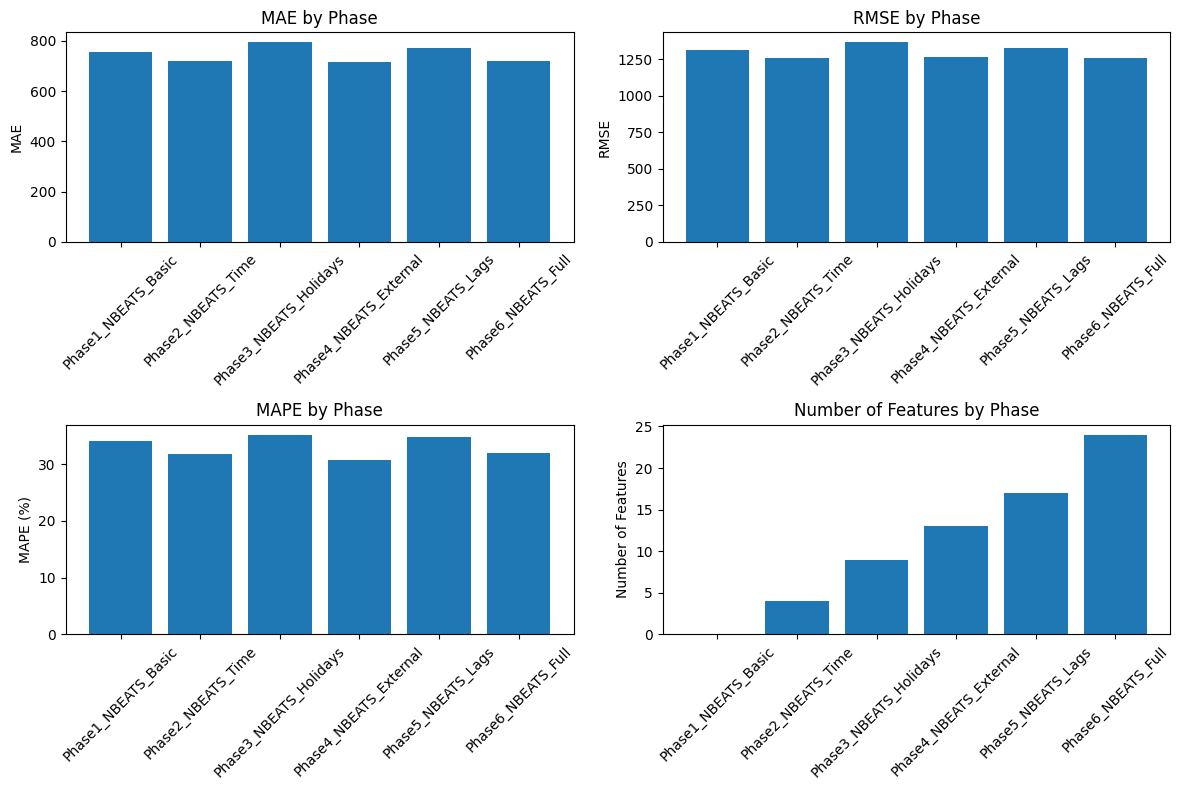


N-BEATS EXPERIMENT COMPLETED SUCCESSFULLY!
🏆 BEST MODEL: Phase4_NBEATS_External
📊 PERFORMANCE: MAE 717.68 | RMSE 1264.93 | MAPE 30.78%
🔧 FEATURES: 13 features
📝 DESCRIPTION: N-BEATS with time, holiday, and external features

🔗 COMPARISON WITH PROPHET:
   Prophet (Phase1_Baseline): MAE ~1552
   N-BEATS (Phase4_NBEATS_External): MAE 717.68
   🎉 N-BEATS OUTPERFORMS Prophet by 834.32 MAE points!

📁 MODEL SAVED TO MLFLOW MODEL REGISTRY: 'NBEATS_Sales_Forecasting'
📊 RESULTS SAVED TO: 'nbeats_phase_comparison.csv'
✅ Ready for model inference!


In [19]:
comparison_df.to_csv('nbeats_phase_comparison.csv', index=False)
print("Phase comparison results saved to 'nbeats_phase_comparison.csv'")

# Log final summary
with mlflow.start_run(run_name="NBEATS_Final_Summary"):
    if best_phase_name:
        mlflow.log_param("best_phase", best_phase_name)
        mlflow.log_metric("best_mae", best_phase['MAE'])
        mlflow.log_metric("best_rmse", best_phase['RMSE'])
        mlflow.log_metric("best_mape", best_phase['MAPE'])

    mlflow.log_param("total_phases_tested", len(phase_comparison))
    mlflow.log_artifact('nbeats_phase_comparison.csv')

    # Create and log a summary plot
    if len(comparison_df) > 0:
        plt.figure(figsize=(12, 8))

        # MAE comparison
        plt.subplot(2, 2, 1)
        plt.bar(comparison_df['Phase'], comparison_df['MAE'])
        plt.title('MAE by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('MAE')

        # RMSE comparison
        plt.subplot(2, 2, 2)
        plt.bar(comparison_df['Phase'], comparison_df['RMSE'])
        plt.title('RMSE by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('RMSE')

        # MAPE comparison
        plt.subplot(2, 2, 3)
        plt.bar(comparison_df['Phase'], comparison_df['MAPE'])
        plt.title('MAPE by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('MAPE (%)')

        # Number of features
        plt.subplot(2, 2, 4)
        plt.bar(comparison_df['Phase'], comparison_df['N_Features'])
        plt.title('Number of Features by Phase')
        plt.xticks(rotation=45)
        plt.ylabel('Number of Features')

        plt.tight_layout()
        plt.savefig('nbeats_phase_comparison.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('nbeats_phase_comparison.png')
        plt.show()

print("\n" + "="*80)
print("N-BEATS EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*80)

if best_phase_name:
    print(f"🏆 BEST MODEL: {best_phase_name}")
    print(f"📊 PERFORMANCE: MAE {best_phase['MAE']:.2f} | RMSE {best_phase['RMSE']:.2f} | MAPE {best_phase['MAPE']:.2f}%")
    print(f"🔧 FEATURES: {len(best_config['features'])} features")
    print(f"📝 DESCRIPTION: {best_config['description']}")

    print(f"\n🔗 COMPARISON WITH PROPHET:")
    print(f"   Prophet (Phase1_Baseline): MAE ~1552")
    print(f"   N-BEATS ({best_phase_name}): MAE {best_phase['MAE']:.2f}")

    if best_phase['MAE'] < 1552:
        print(f"   🎉 N-BEATS OUTPERFORMS Prophet by {1552 - best_phase['MAE']:.2f} MAE points!")
    else:
        print(f"   📈 Prophet still leads by {best_phase['MAE'] - 1552:.2f} MAE points")

print(f"\n📁 MODEL SAVED TO MLFLOW MODEL REGISTRY: 'NBEATS_Sales_Forecasting'")
print(f"📊 RESULTS SAVED TO: 'nbeats_phase_comparison.csv'")
print("✅ Ready for model inference!")
print("="*80)